In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary

from common import *
from ViT import ViT
from GaitData import GaitData

In [2]:
train_data = GaitData('GEI.pt', types=TRAIN_TYPE, labels=TRAIN_LABEL)
valid_data = GaitData('GEI.pt', types=VALID_TYPE, labels=TRAIN_LABEL)
print(len(train_data))
print(len(valid_data))

4620
2640


0
torch.Size([1, 64, 64])


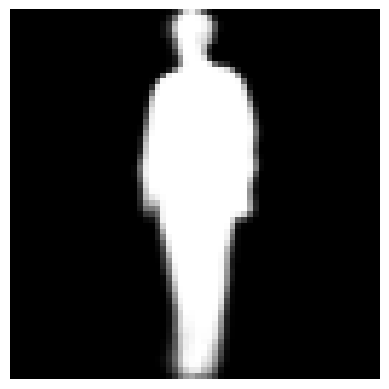

In [3]:
img, label = train_data[0]
print(label)
print(img.shape)
img = img.squeeze(0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [5]:
num_classes = len(TRAIN_LABEL)
print(f'num_classes: {num_classes}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViT(img_size=64,
            in_chanels=1,
            patch_size=32,
            embed_dim=512,
            num_encoders=6,
            num_heads=8,
            hidden_dim=1024,
            dropout=0.2,
            num_classes=num_classes).to(device)

print(summary(model))

criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

num_classes: 60
Layer (type:depth-idx)                                       Param #
ViT                                                          --
├─PatchEmbedding: 1-1                                        --
│    └─Unfold: 2-1                                           --
│    └─Linear: 2-2                                           524,800
├─ClassToken: 1-2                                            512
├─PositionEmbeding: 1-3                                      2,560
├─Sequential: 1-4                                            --
│    └─TransformerEncoder: 2-3                               --
│    │    └─LayerNorm: 3-1                                   1,024
│    │    └─MultiheadAttention: 3-2                          1,050,624
│    │    └─LayerNorm: 3-3                                   1,024
│    │    └─Sequential: 3-4                                  1,050,112
│    └─TransformerEncoder: 2-4                               --
│    │    └─LayerNorm: 3-5                            

In [6]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                        
        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [7]:
def valid(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [8]:
train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []

num_epoches = 30
for epoch in range(1, num_epoches+1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = valid(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {valid_loss:.4f}, Test Acc: {valid_acc:.2f}%")

Epoch 1:
  Train Loss: 4.1648, Train Acc: 1.88%
  Test Loss: 4.0744, Test Acc: 1.67%
Epoch 2:
  Train Loss: 3.5027, Train Acc: 11.30%
  Test Loss: 2.6622, Test Acc: 27.79%
Epoch 3:
  Train Loss: 2.4678, Train Acc: 33.31%
  Test Loss: 2.0538, Test Acc: 44.44%
Epoch 4:
  Train Loss: 1.7452, Train Acc: 53.72%
  Test Loss: 1.4282, Test Acc: 62.21%
Epoch 5:
  Train Loss: 1.2105, Train Acc: 69.50%
  Test Loss: 0.8240, Test Acc: 80.82%
Epoch 6:
  Train Loss: 0.8053, Train Acc: 80.71%
  Test Loss: 0.6163, Test Acc: 84.91%
Epoch 7:
  Train Loss: 0.5336, Train Acc: 88.14%
  Test Loss: 0.3367, Test Acc: 92.62%
Epoch 8:
  Train Loss: 0.3795, Train Acc: 91.90%
  Test Loss: 0.2342, Test Acc: 95.56%
Epoch 9:
  Train Loss: 0.2657, Train Acc: 95.15%
  Test Loss: 0.1581, Test Acc: 97.14%
Epoch 10:
  Train Loss: 0.2088, Train Acc: 96.10%
  Test Loss: 0.0959, Test Acc: 98.46%
Epoch 11:
  Train Loss: 0.1427, Train Acc: 97.75%
  Test Loss: 0.0653, Test Acc: 99.18%
Epoch 12:
  Train Loss: 0.1161, Train Acc: 

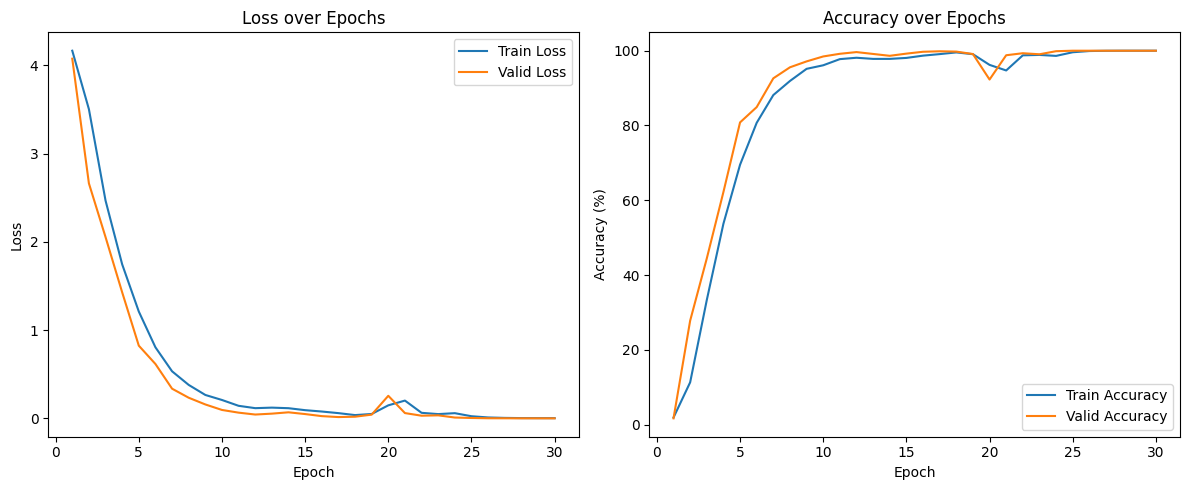

In [9]:
epochs = range(1, num_epoches + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(), 'GaitViT_model.pth')